# Feature Engineering

**Objective**: Extract meaningful features from resume text for ML models

## Features to Create:
1. Skills extraction using NLP
2. Experience level indicators
3. Education features
4. Text-based features (TF-IDF)
5. Derived/composite features
6. Feature encoding for ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded")

✓ Libraries loaded


In [2]:
# Load spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
    print("✓ spaCy model loaded")
except OSError:
    print("! spaCy model not found. Please run: python -m spacy download en_core_web_sm")
    nlp = None

✓ spaCy model loaded


## 1. Load Processed Data

In [3]:
# Load cleaned data from previous step
df = pd.read_csv('../data/processed/resumes_cleaned.csv')

print(f"✓ Loaded processed data: {df.shape}")
print(f"  Columns: {df.columns.tolist()}")
df.head()

✓ Loaded processed data: (495, 17)
  Columns: ['ID', 'Category', 'Resume', 'Experience_Years', 'Education_Level', 'Skills', 'Num_Skills', 'Has_Certification', 'Num_Companies', 'Resume_str', 'Resume_html', 'Resume_Clean', 'Resume_Length', 'Resume_Word_Count', 'Experience_Years_is_outlier', 'Num_Skills_is_outlier', 'Num_Companies_is_outlier']


,ID,Category,Resume,Experience_Years,Education_Level,Skills,Num_Skills,Has_Certification,Num_Companies,Resume_str,Resume_html,Resume_Clean,Resume_Length,Resume_Word_Count,Experience_Years_is_outlier,Num_Skills_is_outlier,Num_Companies_is_outlier
0,SYN_0001,Web Development,Full Stack Developer with 3 years of experienc...,3.0,Bachelor's,"Node.js, CSS, JavaScript, Redux, Vue.js, Expre...",8.0,False,1.0,Unknown,Unknown,Full Stack Developer with 3 years of experienc...,419,56,False,False,False
1,SYN_0002,Web Development,Full Stack Developer with 9 years of experienc...,9.0,Bachelor's,"Node.js, REST APIs, MySQL, Vue.js, PostgreSQL,...",13.0,False,3.0,Unknown,Unknown,Full Stack Developer with 9 years of experienc...,660,90,False,False,False
2,SYN_0003,Software Engineering,Software Engineer with 6 years of experience. ...,6.0,Master's,"Go, Programming, SQL, JavaScript, Algorithms, ...",11.0,False,2.0,Unknown,Unknown,Software Engineer with 6 years of experience. ...,545,74,False,False,False
3,SYN_0004,Web Development,Full Stack Developer with 5 years of experienc...,5.0,Master's,"Node.js, CSS, Angular, JavaScript, MySQL, Vue....",10.0,True,1.0,Unknown,Unknown,Full Stack Developer with 5 years of experienc...,519,66,False,False,False
4,SYN_0005,Network Engineering,Network Engineer with 2 years of experience. S...,2.0,Bachelor's,"Networking, Load Balancer, TCP/IP, Security, W...",7.0,False,1.0,Unknown,Unknown,Network Engineer with 2 years of experience. S...,442,56,False,False,False


## 2. Skills Extraction using NLP

We'll extract skills using:
1. Predefined skill lists (common tech skills)
2. Named Entity Recognition (NER)
3. Pattern matching

In [4]:
# Define comprehensive skill database
SKILLS_DATABASE = {
    'programming_languages': [
        'python', 'java', 'javascript', 'c++', 'c#', 'ruby', 'php', 'swift',
        'kotlin', 'go', 'rust', 'typescript', 'r', 'matlab', 'scala', 'perl'
    ],
    'web_technologies': [
        'html', 'css', 'react', 'angular', 'vue', 'node.js', 'django', 'flask',
        'express', 'next.js', 'nuxt', 'jquery', 'bootstrap', 'tailwind',
        'webpack', 'babel', 'sass', 'less'
    ],
    'databases': [
        'sql', 'mysql', 'postgresql', 'mongodb', 'redis', 'cassandra',
        'dynamodb', 'oracle', 'sql server', 'sqlite', 'elasticsearch',
        'neo4j', 'firebase'
    ],
    'data_science': [
        'machine learning', 'deep learning', 'nlp', 'computer vision',
        'data analysis', 'statistics', 'pandas', 'numpy', 'scikit-learn',
        'tensorflow', 'pytorch', 'keras', 'spark', 'hadoop', 'tableau',
        'power bi', 'data visualization', 'big data'
    ],
    'cloud_devops': [
        'aws', 'azure', 'gcp', 'docker', 'kubernetes', 'jenkins', 'ci/cd',
        'terraform', 'ansible', 'git', 'github', 'gitlab', 'linux',
        'bash', 'shell scripting', 'monitoring', 'prometheus', 'grafana'
    ],
    'mobile': [
        'android', 'ios', 'react native', 'flutter', 'xamarin',
        'mobile development', 'swift', 'kotlin', 'objective-c'
    ],
    'design': [
        'ui/ux', 'figma', 'adobe xd', 'sketch', 'photoshop', 'illustrator',
        'invision', 'wireframing', 'prototyping', 'user research'
    ],
    'soft_skills': [
        'agile', 'scrum', 'kanban', 'project management', 'leadership',
        'communication', 'teamwork', 'problem solving', 'critical thinking'
    ],
    'other_technical': [
        'rest api', 'graphql', 'microservices', 'testing', 'unit testing',
        'integration testing', 'tdd', 'oop', 'design patterns', 'algorithms',
        'data structures', 'system design', 'security', 'networking'
    ]
}

# Flatten all skills into one list
ALL_SKILLS = []
for category, skills in SKILLS_DATABASE.items():
    ALL_SKILLS.extend(skills)

ALL_SKILLS = list(set(ALL_SKILLS))  # Remove duplicates
print(f"✓ Skill database loaded: {len(ALL_SKILLS)} skills across {len(SKILLS_DATABASE)} categories")

✓ Skill database loaded: 123 skills across 9 categories


In [5]:
def extract_skills(text, skill_list):
    """
    Extract skills from text using pattern matching.
    
    Args:
        text (str): Resume text
        skill_list (list): List of skills to search for
    
    Returns:
        list: Found skills
    """
    if pd.isna(text):
        return []
    
    text_lower = text.lower()
    found_skills = []
    
    for skill in skill_list:
        # Use word boundaries to avoid partial matches
        pattern = r'\b' + re.escape(skill.lower()) + r'\b'
        if re.search(pattern, text_lower):
            found_skills.append(skill)
    
    return found_skills

# Extract skills from resumes
print("Extracting skills from resumes...")
df['Extracted_Skills'] = df['Resume_Clean'].apply(lambda x: extract_skills(x, ALL_SKILLS))
df['Num_Skills'] = df['Extracted_Skills'].apply(len)

print(f"✓ Skills extracted")
print(f"  Avg skills per resume: {df['Num_Skills'].mean():.2f}")
print(f"  Max skills: {df['Num_Skills'].max()}")
print(f"  Min skills: {df['Num_Skills'].min()}")

Extracting skills from resumes...
✓ Skills extracted
  Avg skills per resume: 6.39
  Max skills: 15
  Min skills: 0



Top 20 Most Common Skills:
git                 :  150 resumes (30.3%)
sql                 :  122 resumes (24.6%)
python              :  116 resumes (23.4%)
security            :  114 resumes (23.0%)
machine learning    :  102 resumes (20.6%)
aws                 :   98 resumes (19.8%)
azure               :   88 resumes (17.8%)
statistics          :   83 resumes (16.8%)
pytorch             :   74 resumes (14.9%)
scikit-learn        :   71 resumes (14.3%)
javascript          :   68 resumes (13.7%)
tensorflow          :   65 resumes (13.1%)
mongodb             :   64 resumes (12.9%)
testing             :   59 resumes (11.9%)
mysql               :   58 resumes (11.7%)
postgresql          :   56 resumes (11.3%)
ci/cd               :   56 resumes (11.3%)
numpy               :   54 resumes (10.9%)
pandas              :   52 resumes (10.5%)
data analysis       :   51 resumes (10.3%)


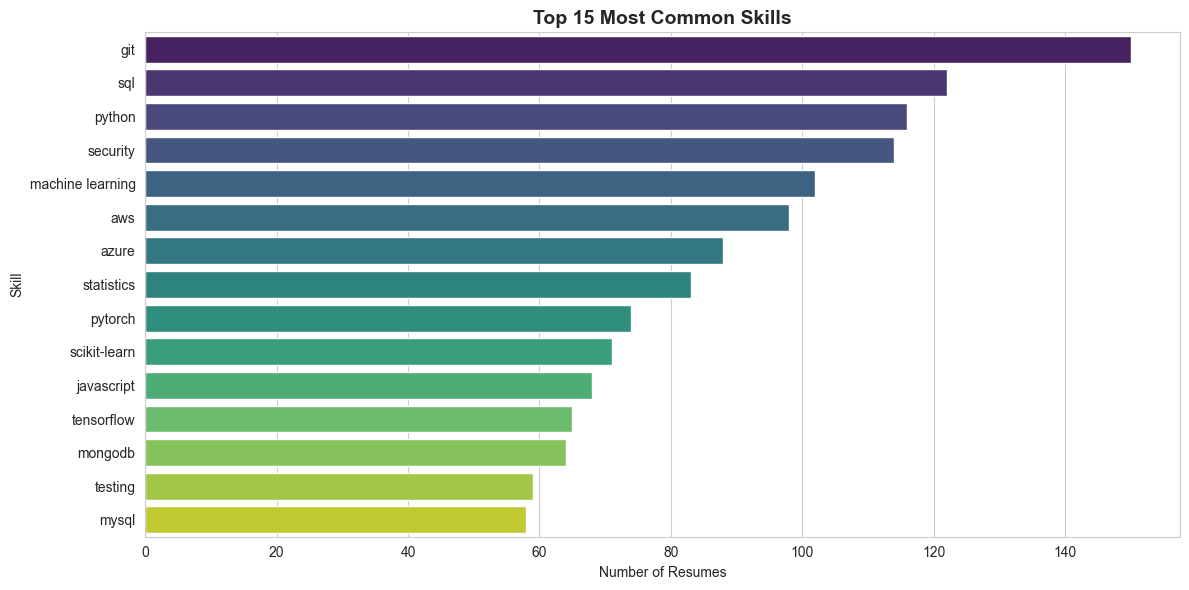

In [6]:
# Analyze skill distribution
all_extracted_skills = [skill for skills in df['Extracted_Skills'] for skill in skills]
skill_counts = Counter(all_extracted_skills)

print("\nTop 20 Most Common Skills:")
print("="*60)
for skill, count in skill_counts.most_common(20):
    percentage = (count / len(df)) * 100
    print(f"{skill:20s}: {count:4d} resumes ({percentage:.1f}%)")

# Visualize top skills
top_skills_df = pd.DataFrame(skill_counts.most_common(15), columns=['Skill', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(data=top_skills_df, x='Count', y='Skill', palette='viridis')
plt.title('Top 15 Most Common Skills', fontsize=14, fontweight='bold')
plt.xlabel('Number of Resumes')
plt.ylabel('Skill')
plt.tight_layout()
plt.show()

In [7]:
# Extract skills by category
for category, skills in SKILLS_DATABASE.items():
    col_name = f'Skills_{category}'
    df[col_name] = df['Resume_Clean'].apply(lambda x: extract_skills(x, skills))
    df[f'Num_{category}'] = df[col_name].apply(len)

print("✓ Skills categorized")
print("\nSkills by Category:")
for category in SKILLS_DATABASE.keys():
    avg_skills = df[f'Num_{category}'].mean()
    print(f"  {category:20s}: {avg_skills:.2f} avg")

✓ Skills categorized

Skills by Category:
  programming_languages: 0.66 avg
  web_technologies    : 0.53 avg
  databases           : 1.06 avg
  data_science        : 1.30 avg
  cloud_devops        : 1.29 avg
  mobile              : 0.26 avg
  design              : 0.58 avg
  soft_skills         : 0.02 avg
  other_technical     : 0.78 avg


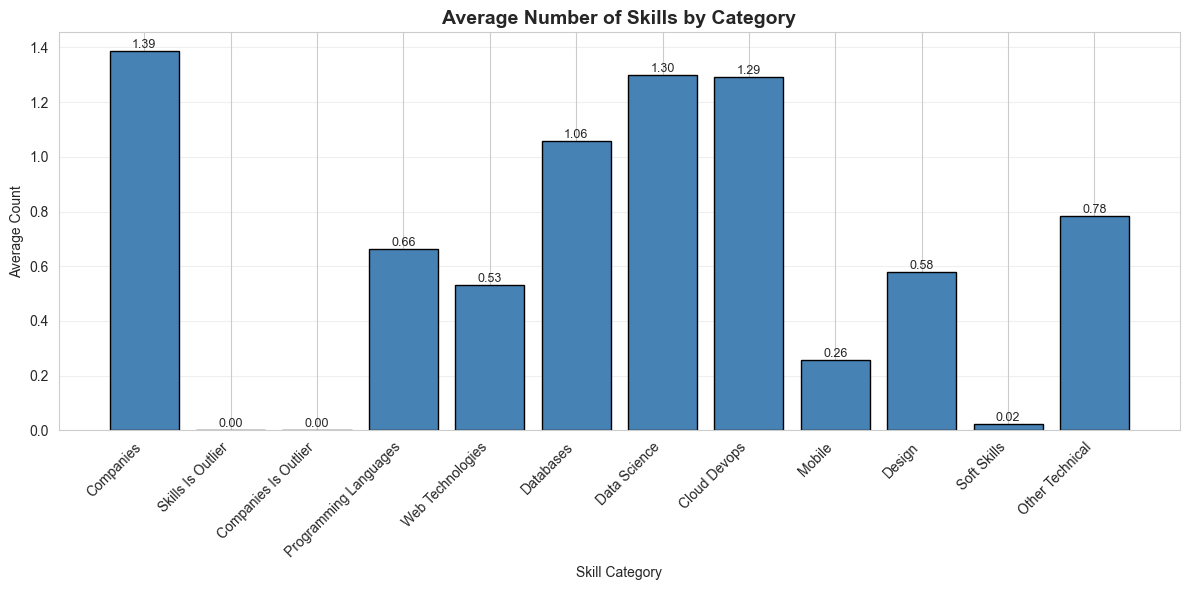

In [8]:
# Visualize skills distribution across categories
category_cols = [col for col in df.columns if col.startswith('Num_') and col != 'Num_Skills']
category_names = [col.replace('Num_', '').replace('_', ' ').title() for col in category_cols]

avg_by_category = df[category_cols].mean()

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(category_names)), avg_by_category, color='steelblue', edgecolor='black')
plt.xticks(range(len(category_names)), category_names, rotation=45, ha='right')
plt.title('Average Number of Skills by Category', fontsize=14, fontweight='bold')
plt.ylabel('Average Count')
plt.xlabel('Skill Category')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 3. Experience Level Extraction

In [9]:
def extract_years_of_experience(text):
    """
    Extract years of experience from resume text.
    
    Args:
        text (str): Resume text
    
    Returns:
        int: Estimated years of experience
    """
    if pd.isna(text):
        return 0
    
    # Patterns to match experience mentions
    patterns = [
        r'(\d+)\+?\s*years?\s+(?:of\s+)?experience',
        r'experience\s*:?\s*(\d+)\+?\s*years?',
        r'(\d+)\+?\s*yrs?\s+(?:of\s+)?experience',
    ]
    
    years = []
    text_lower = text.lower()
    
    for pattern in patterns:
        matches = re.findall(pattern, text_lower)
        years.extend([int(m) for m in matches])
    
    # Return the maximum found (most likely to be total experience)
    return max(years) if years else None

# Extract experience if not already present
if 'Experience_Years' not in df.columns:
    print("Extracting years of experience...")
    df['Experience_Years'] = df['Resume_Clean'].apply(extract_years_of_experience)
    print(f"✓ Experience extracted")
    print(f"  Found in {df['Experience_Years'].notna().sum()} resumes")
else:
    print("✓ Experience years already present")

# Create experience level categories
def categorize_experience(years):
    if pd.isna(years) or years == 0:
        return 'Entry Level'
    elif years <= 2:
        return 'Junior'
    elif years <= 5:
        return 'Mid-Level'
    elif years <= 8:
        return 'Senior'
    else:
        return 'Expert'

df['Experience_Level'] = df['Experience_Years'].apply(categorize_experience)

print("\nExperience Distribution:")
print(df['Experience_Level'].value_counts())

✓ Experience years already present

Experience Distribution:
Experience_Level
Mid-Level    185
Junior       154
Senior       121
Expert        35
Name: count, dtype: int64


## 4. Education Features

✓ Education level already present

Education Distribution:
Education_Level
Bachelor's                   237
Master's                     201
PhD in Computer Science's     57
Name: count, dtype: int64


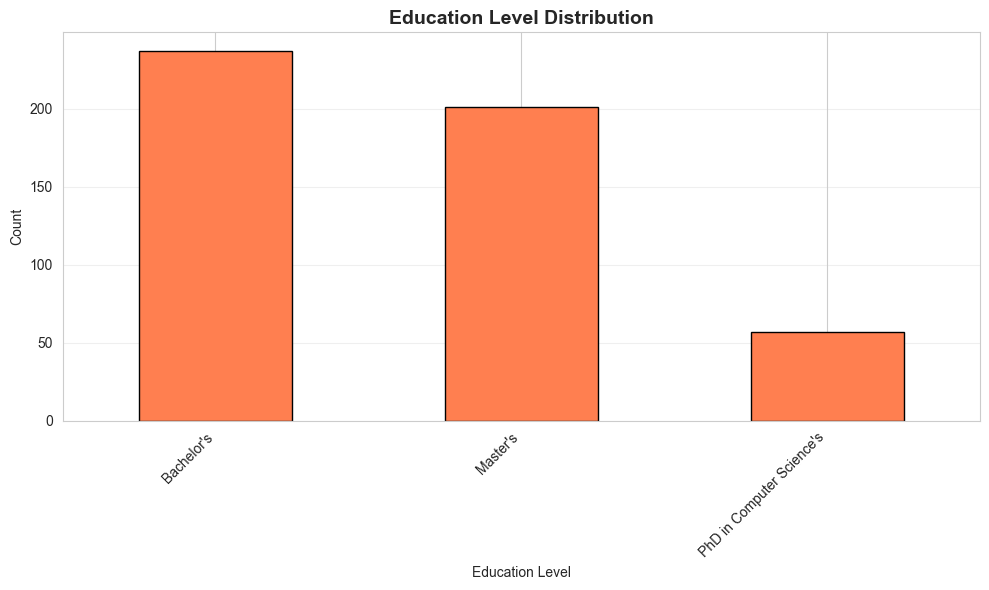

In [10]:
def extract_education_level(text):
    """
    Extract highest education level from resume.
    
    Args:
        text (str): Resume text
    
    Returns:
        str: Education level
    """
    if pd.isna(text):
        return 'Not Specified'
    
    text_lower = text.lower()
    
    # Check in order of priority
    if any(word in text_lower for word in ['phd', 'ph.d', 'doctorate']):
        return "PhD"
    elif any(word in text_lower for word in ["master's", 'masters', 'msc', 'm.sc', 'mba', 'm.b.a']):
        return "Master's"
    elif any(word in text_lower for word in ["bachelor's", 'bachelors', 'bsc', 'b.sc', 'b.tech', 'btech', 'bs', 'ba']):
        return "Bachelor's"
    elif any(word in text_lower for word in ['diploma', 'associate']):
        return 'Diploma'
    else:
        return 'Not Specified'

# Extract education if not present
if 'Education_Level' not in df.columns:
    print("Extracting education level...")
    df['Education_Level'] = df['Resume_Clean'].apply(extract_education_level)
    print("✓ Education extracted")
else:
    print("✓ Education level already present")

print("\nEducation Distribution:")
print(df['Education_Level'].value_counts())

# Visualize
plt.figure(figsize=(10, 6))
df['Education_Level'].value_counts().plot(kind='bar', color='coral', edgecolor='black')
plt.title('Education Level Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 5. TF-IDF Features for Text Similarity

In [11]:
# Create TF-IDF features (for matching/similarity)
print("Creating TF-IDF features...")

tfidf = TfidfVectorizer(
    max_features=100,  # Top 100 terms
    stop_words='english',
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,  # Must appear in at least 2 documents
    max_df=0.8  # Must not appear in more than 80% of documents
)

tfidf_matrix = tfidf.fit_transform(df['Resume_Clean'])

print(f"✓ TF-IDF matrix created: {tfidf_matrix.shape}")
print(f"  Features: {len(tfidf.get_feature_names_out())}")

# Get feature names
feature_names = tfidf.get_feature_names_out()
print(f"\nTop 20 TF-IDF terms:")
print(feature_names[:20])

Creating TF-IDF features...
✓ TF-IDF matrix created: (495, 100)
  Features: 100

Top 20 TF-IDF terms:
['analysis' 'assessment' 'aws' 'bachelor' 'background'
 'background developing' 'certifications' 'certified' 'cloud' 'computer'
 'computer science' 'contributed' 'contributed various' 'data'
 'data analysis' 'database' 'deploying' 'deploying solutions' 'design'
 'developer']


In [12]:
# Save TF-IDF vectorizer for later use
import joblib

joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')
print("✓ TF-IDF vectorizer saved")

✓ TF-IDF vectorizer saved


## 6. Derived/Composite Features

In [13]:
# Create derived features
print("Creating derived features...")

# Skill diversity score (ratio of unique skill categories with skills)
skill_category_cols = [col for col in df.columns if col.startswith('Num_') and col != 'Num_Skills']
df['Skill_Diversity'] = (df[skill_category_cols] > 0).sum(axis=1) / len(skill_category_cols)

# Technical depth (number of technical skills relative to total)
technical_cols = ['Num_programming_languages', 'Num_web_technologies', 'Num_databases', 
                  'Num_data_science', 'Num_cloud_devops']
technical_cols = [col for col in technical_cols if col in df.columns]
df['Technical_Skills_Count'] = df[technical_cols].sum(axis=1)
df['Technical_Ratio'] = df['Technical_Skills_Count'] / (df['Num_Skills'] + 1)  # +1 to avoid division by zero

# Certification indicator
if 'Has_Certification' not in df.columns:
    cert_keywords = ['certified', 'certification', 'certificate', 'accredited']
    df['Has_Certification'] = df['Resume_Clean'].apply(
        lambda x: any(keyword in x.lower() for keyword in cert_keywords)
    )

# Leadership indicator
leadership_keywords = ['lead', 'leader', 'manage', 'manager', 'director', 'head of', 'team lead']
df['Has_Leadership'] = df['Resume_Clean'].apply(
    lambda x: any(keyword in x.lower() for keyword in leadership_keywords)
)

print("✓ Derived features created")
print(f"  Skill Diversity (avg): {df['Skill_Diversity'].mean():.3f}")
print(f"  Technical Ratio (avg): {df['Technical_Ratio'].mean():.3f}")
print(f"  Has Certification: {df['Has_Certification'].sum()} ({df['Has_Certification'].sum()/len(df)*100:.1f}%)")
print(f"  Has Leadership: {df['Has_Leadership'].sum()} ({df['Has_Leadership'].sum()/len(df)*100:.1f}%)")

Creating derived features...
✓ Derived features created
  Skill Diversity (avg): 0.283
  Technical Ratio (avg): 0.552
  Has Certification: 210 (42.4%)
  Has Leadership: 216 (43.6%)


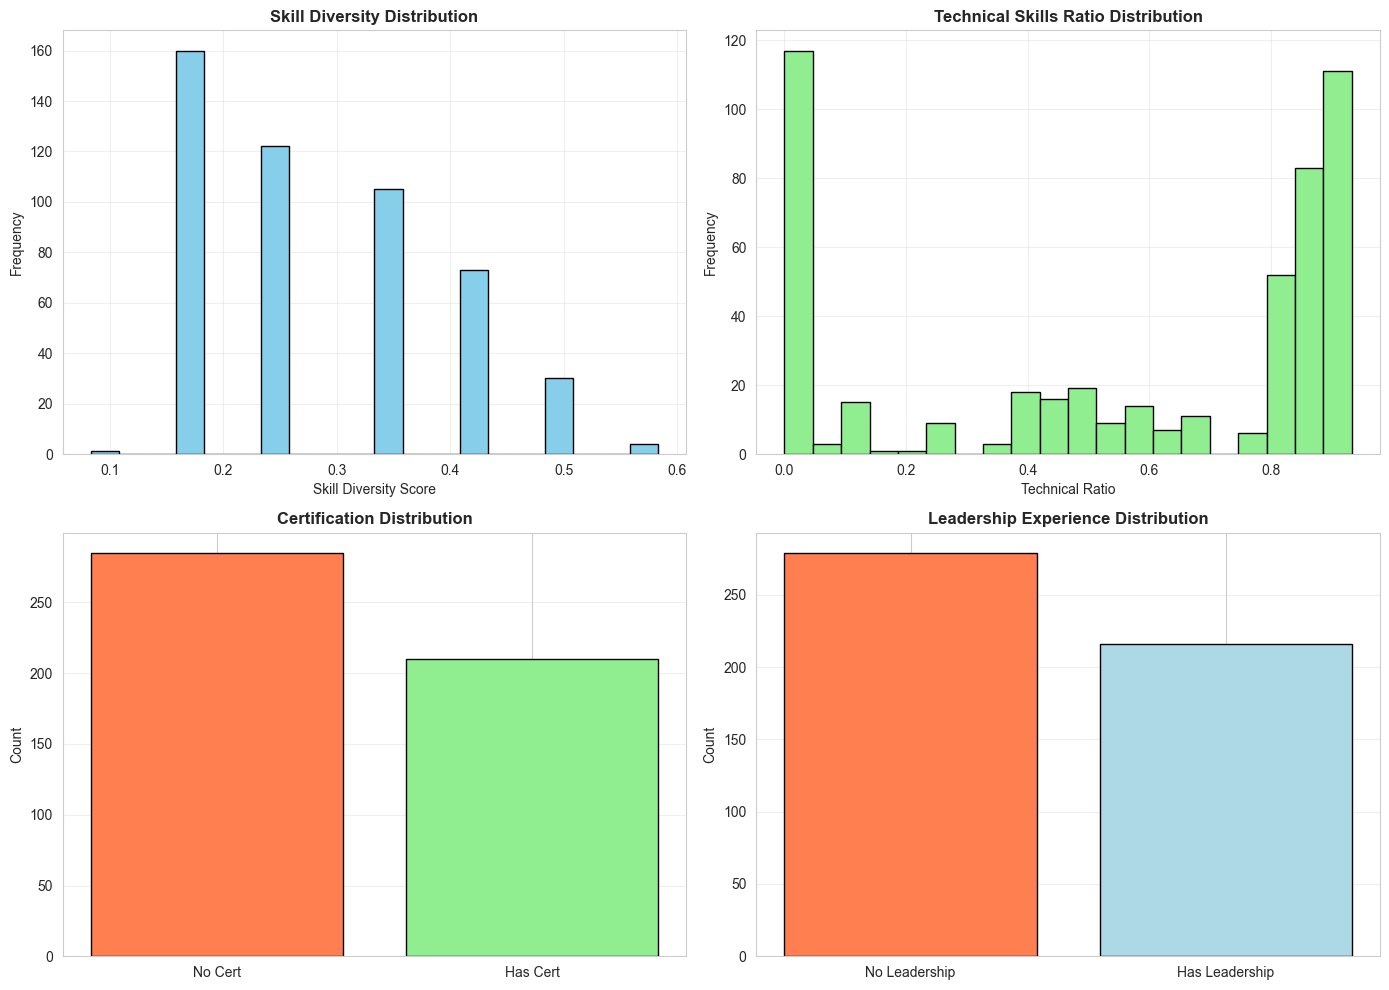

In [14]:
# Visualize derived features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Skill diversity
axes[0, 0].hist(df['Skill_Diversity'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Skill Diversity Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Skill Diversity Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Technical ratio
axes[0, 1].hist(df['Technical_Ratio'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Technical Skills Ratio Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Technical Ratio')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Certifications
cert_counts = df['Has_Certification'].value_counts()
axes[1, 0].bar(['No Cert', 'Has Cert'], cert_counts.values, color=['coral', 'lightgreen'], edgecolor='black')
axes[1, 0].set_title('Certification Distribution', fontweight='bold')
axes[1, 0].set_ylabel('Count')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Leadership
lead_counts = df['Has_Leadership'].value_counts()
axes[1, 1].bar(['No Leadership', 'Has Leadership'], lead_counts.values, color=['coral', 'lightblue'], edgecolor='black')
axes[1, 1].set_title('Leadership Experience Distribution', fontweight='bold')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Feature Encoding for ML

In [15]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical variables
print("Encoding categorical features...")

# Label encoding for ordinal features
education_order = {'Not Specified': 0, 'Diploma': 1, "Bachelor's": 2, "Master's": 3, 'PhD': 4}
df['Education_Level_Encoded'] = df['Education_Level'].map(education_order)

experience_order = {'Entry Level': 0, 'Junior': 1, 'Mid-Level': 2, 'Senior': 3, 'Expert': 4}
df['Experience_Level_Encoded'] = df['Experience_Level'].map(experience_order)

# One-hot encoding for Category if it exists
if 'Category' in df.columns:
    category_dummies = pd.get_dummies(df['Category'], prefix='Category')
    df = pd.concat([df, category_dummies], axis=1)
    print(f"  Category one-hot encoded: {len(category_dummies.columns)} columns")

# Boolean encoding
df['Has_Certification_Encoded'] = df['Has_Certification'].astype(int)
df['Has_Leadership_Encoded'] = df['Has_Leadership'].astype(int)

print("✓ Categorical encoding complete")

Encoding categorical features...
  Category one-hot encoded: 10 columns
✓ Categorical encoding complete


In [16]:
# Select features for ML models
ml_features = [
    'Num_Skills',
    'Resume_Length',
    'Resume_Word_Count',
    'Experience_Years',
    'Experience_Level_Encoded',
    'Education_Level_Encoded',
    'Skill_Diversity',
    'Technical_Skills_Count',
    'Technical_Ratio',
    'Has_Certification_Encoded',
    'Has_Leadership_Encoded'
]

# Add category columns if they exist
category_cols = [col for col in df.columns if col.startswith('Category_')]
ml_features.extend(category_cols)

# Add skill category counts
skill_cat_cols = [col for col in df.columns if col.startswith('Num_') and col not in ml_features]
ml_features.extend(skill_cat_cols)

# Filter to only existing columns
ml_features = [col for col in ml_features if col in df.columns]

print(f"\nSelected {len(ml_features)} features for ML:")
print(ml_features)


Selected 33 features for ML:
['Num_Skills', 'Resume_Length', 'Resume_Word_Count', 'Experience_Years', 'Experience_Level_Encoded', 'Education_Level_Encoded', 'Skill_Diversity', 'Technical_Skills_Count', 'Technical_Ratio', 'Has_Certification_Encoded', 'Has_Leadership_Encoded', 'Category_Cybersecurity', 'Category_Data Science', 'Category_Database Administration', 'Category_DevOps', 'Category_Machine Learning', 'Category_Mobile Development', 'Category_Network Engineering', 'Category_Software Engineering', 'Category_UI/UX Design', 'Category_Web Development', 'Num_Companies', 'Num_Skills_is_outlier', 'Num_Companies_is_outlier', 'Num_programming_languages', 'Num_web_technologies', 'Num_databases', 'Num_data_science', 'Num_cloud_devops', 'Num_mobile', 'Num_design', 'Num_soft_skills', 'Num_other_technical']


In [17]:
# Handle missing values in ML features
df[ml_features] = df[ml_features].fillna(df[ml_features].median())

# Standardize numerical features
numerical_features = df[ml_features].select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

print("✓ Features standardized")

# Save scaler
joblib.dump(scaler, '../models/feature_scaler.pkl')
print("✓ Scaler saved")

✓ Features standardized
✓ Scaler saved


## 8. Feature Summary and Correlation Analysis

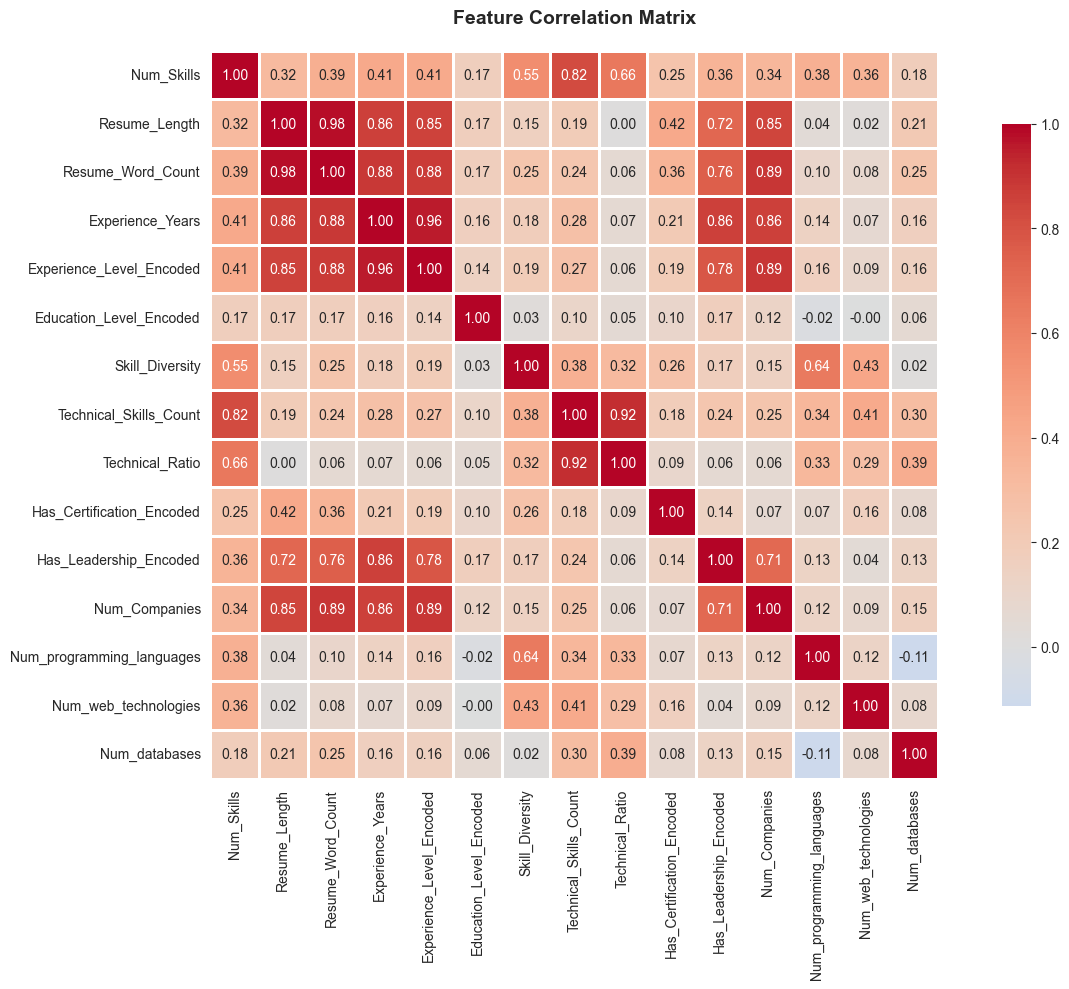

In [18]:
# Correlation matrix
correlation_features = [col for col in ml_features if col in numerical_features][:15]  # Top 15 for visibility

plt.figure(figsize=(14, 10))
correlation_matrix = df[correlation_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 9. Save Feature-Engineered Data

In [19]:
# Save complete dataset with all features
output_path = '../data/processed/resumes_with_features.csv'
df.to_csv(output_path, index=False)

print(f"✓ Feature-engineered data saved: {output_path}")
print(f"  Shape: {df.shape}")
print(f"  Total features: {len(df.columns)}")
print(f"  ML-ready features: {len(ml_features)}")

# Save feature list
import json
with open('../models/ml_features.json', 'w') as f:
    json.dump(ml_features, f, indent=2)
print("✓ Feature list saved")

print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE!")
print("="*60)
print("Next step: Clustering and Modeling (Notebook 04)")

✓ Feature-engineered data saved: ../data/processed/resumes_with_features.csv
  Shape: (495, 55)
  Total features: 55
  ML-ready features: 33
✓ Feature list saved

FEATURE ENGINEERING COMPLETE!
Next step: Clustering and Modeling (Notebook 04)
